In [1]:
# Add module path for demo.
# Todo: add setup file as pip install tsx
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries

WORK_DIR = ".."
DATA_DIR = f"{WORK_DIR}/tests/data"
assert os.path.exists(DATA_DIR), f"Not found folder {DATA_DIR}"

## Prepare Data Set

In [3]:
def load_data_set_bejin():
    data_link = f"{DATA_DIR}/pollution.csv"
    assert os.path.exists(data_link), f"Not found folder {data_link}"
    df = pd.read_csv(data_link)

    # Set date-time as index
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    return df

## LIME for Time Series

### Load data

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

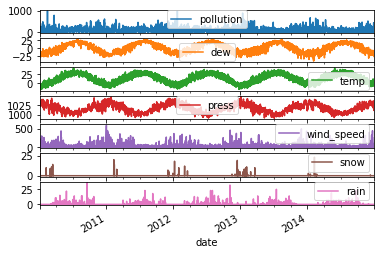

In [4]:
# Prepare data set
df = load_data_set_bejin()

# Encoding wind_direction to integer
encoder = LabelEncoder()
df["wind_direction"] = encoder.fit_transform(df["wind_direction"])

# Normalization
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(df[independents].values)
y_scaler.fit(df[dependent].values.reshape(-1, 1))

# Visualize the dataset 
df.loc[:, df.columns != 'wind_direction'].plot(subplots=True)


### Select randomly an instance of X

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

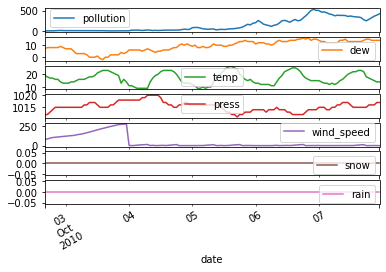

In [5]:
# 1- Load an instance
def get_instance_x(df):
    idx = np.random.randint(0, len(df.index) - 128 - 1)
    return df[idx:idx + 128].copy()

x = get_instance_x(df)
x.loc[:, df.columns != 'wind_direction'].plot(subplots=True)

### Predict Function or explaining models

In [6]:
# Prepare predict function
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")

def predict_fn(z, model=lstm):
    z = z.reshape(1, 128, 7)
    z_hat = model.predict(z)
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = z_hat.ravel()   # z_hat will arround 50 - 150
    return z_hat[0]

### Fitting the explaining model by using LIME Time Series

In [7]:
# Convert ts x to a (n_features, n_samples)
x[independents] = x_scaler.transform(x[independents].values)
ts_x = x[independents].values.reshape(7, 128)
# 2- Use LIME for Time Series with default for forecasting.
ts_lime = LIMETimeSeries(window_size=4, sample_size=100)
ts_lime.explain(ts_x, predict_fn=predict_fn)

# Todo: mathematic here

A z_prime is multi-demnsional with shape of (n_features, n_segments). 

1 means keep it as original. 
0 will be perturbed and replaced by replacements_i (default is zero) of that corresponding segment


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

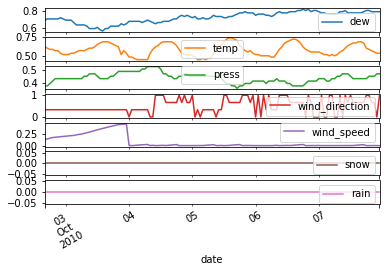

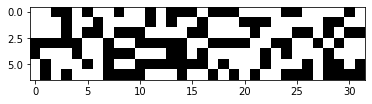

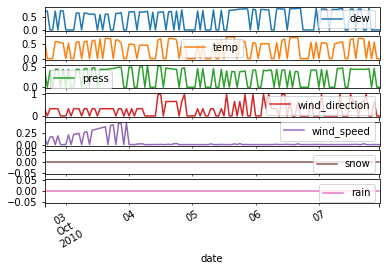

In [8]:
# An instance x
x[independents].plot(subplots=True)

# A z_prime
z_prime, z, z_hat, sample_weight = ts_lime.get_a_local_sample()
color_map = plt.cm.get_cmap('Greys').reversed()
plt.figure()
plt.imshow(z_prime, cmap=color_map)
# white as 1, no perturbed
# black as 0, perturbed segment

# A z
z_df = x.copy()
z_df[independents] = z.reshape(z_df[independents].values.shape)
z_df[independents].plot(subplots=True)
# Notice of zero

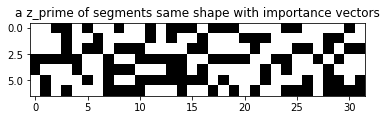

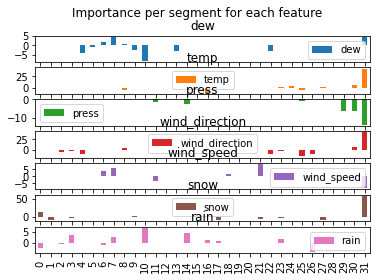

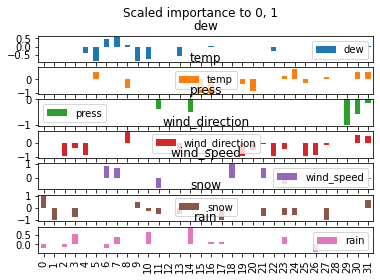

In [9]:
# Replot a z_prime 
plt.imshow(z_prime, cmap=color_map)
plt.title("a z_prime of segments same shape with importance vectors")

# Plot importance
ts_lime.plot_coef(feature_names=independents, title='Importance per segment for each feature')

# Plot importance and scale to 0 and 1 (per each feature)
from sklearn.preprocessing import Normalizer
ts_lime.plot_coef(feature_names=independents, scaler=Normalizer(), title='Scaled importance to 0, 1')

### Multiple run and average

In [ ]:
instances = []
n_instances = 10
for i in range(n_instances):
    _x = get_instance_x(df)
    normalized_x = x_scaler.transform(_x[independents].values)
    ts_x = x[independents].values.reshape(7, 128)
    instances.append(ts_x)

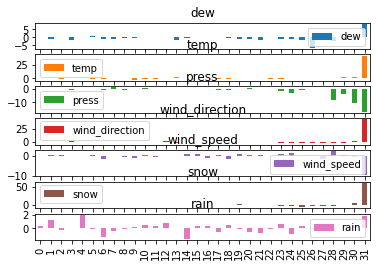

In [10]:
ts_lime = LIMETimeSeries(window_size=4, sample_size=100)
ts_lime.explain_instances(instances, predict_fn=predict_fn)
ts_lime.plot_coef(feature_names=independents)